In [1]:
from __future__ import print_function, division

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

batch_size = 32
learning_rate = 0.0002
Epoch = 20
TRAIN = True
dataPath = '../DBtest/img/'
checkPointPath = '../DBtest/checkPoint/ResNet_checkPoint/'

train_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
test_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
val_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

train_dir = dataPath + 'train'
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

test_dir = dataPath + 'test'
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=True)

val_dir = dataPath + 'val'
val_datasets = datasets.ImageFolder(val_dir, transform=val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True)

  # --------------------模型定义---------------------------------
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        net = models.resnet50(pretrained=False)
        channel_in = net.fc.in_features
        net.fc = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
            nn.Linear(channel_in, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

  # --------------------训练过程---------------------------------
model = ResNet()
if torch.cuda.is_available():
    model.cuda()
    print('Using GPU')

params = [{'params': md.parameters()} for md in model.children()
          if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
start_epoch = 0

if os.path.exists(checkPointPath + 'ResNet_best_18.pth'):
    path_checkpoint = checkPointPath + 'ResNet_best_18.pth'  # 断点路径
    checkpoint = torch.load(path_checkpoint)  # 加载断点
    model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
    optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
    start_epoch = checkpoint['epoch'] + 1  # 设置开始的epoch

if TRAIN:
  if os.path.exists(checkPointPath + 'loss.npy'):
    Loss_list = np.load(checkPointPath + 'loss.npy', allow_pickle=True)
  else:
    Loss_list = []

  if os.path.exists(checkPointPath + 'accuracy.npy'):
    Accuracy_list = np.load(checkPointPath + 'accuracy.npy', allow_pickle=True)
  else:
    Accuracy_list = []

  for epoch in range(start_epoch, Epoch):
    print('epoch {}'.format(epoch))
    # training-----------------------------
    model.train()
    train_loss = 0.
    train_acc = 0.
    print('Training...')
    trainBar = tqdm(total=len(train_dataloader))
    for step, (batch_x, batch_y) in enumerate(train_dataloader):
      if torch.cuda.is_available():
        batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
      else:
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
      out = model(batch_x)
      loss = loss_func(out, batch_y)
      train_loss += loss.data
      pred = torch.max(out, 1)[1]
      train_correct = (pred == batch_y).sum()
      train_acc += train_correct.data
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      trainBar.update(1)
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / len(train_datasets), train_acc / len(train_datasets)))
    trainBar.close()

    # 断点保存
    checkpoint = {
        "net": model.state_dict(),
        'optimizer':optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, checkPointPath + 'ResNet_best_%s.pth' %(str(epoch)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    print('Testing...')
    testBar = tqdm(total=len(val_dataloader))
    for batch_x, batch_y in val_dataloader:
      with torch.no_grad():
        if torch.cuda.is_available():
          batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
        else:
          batch_x, batch_y = Variable(batch_x), Variable(batch_y)
      out = model(batch_x)
      loss = loss_func(out, batch_y)
      eval_loss += loss.data
      pred = torch.max(out, 1)[1]
      num_correct = (pred == batch_y).sum()
      eval_acc += num_correct.data
      testBar.update(1)
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / len(val_datasets), eval_acc / len(val_datasets)))
    testBar.close()

    # 断点保存
    if epoch >= len(Loss_list):
        Loss_list = np.hstack((Loss_list, eval_loss.data.cpu() / len(val_datasets)))
        Accuracy_list = np.hstack((Accuracy_list, 100 * eval_acc.data.cpu() / len(val_datasets)))
    else:
        Loss_list[epoch] = eval_loss.data.cpu() / len(val_datasets)
        Accuracy_list[epoch] = 100 * eval_acc.data.cpu() / len(val_datasets)

    np.save(checkPointPath + 'loss', Loss_list)
    np.save(checkPointPath + 'accuracy', Accuracy_list)

  x1 = range(0, 10)
  x2 = range(0, 10)
  y1 = Accuracy_list
  y2 = Loss_list
  plt.subplot(2, 1, 1)
  plt.plot(x1, y1, 'o-')
  plt.title('Test accuracy vs. epoches')
  plt.ylabel('Test accuracy')
  plt.subplot(2, 1, 2)
  plt.plot(x2, y2, '.-')
  plt.xlabel('Test loss vs. epoches')
  plt.ylabel('Test loss')
  plt.show()
  # plt.savefig("accuracy_loss.jpg")

else:
  model.eval()
  eval_loss = 0.
  eval_acc = 0.
  print('Testing...')
  testBar = tqdm(total=len(test_dataloader))
  for batch_x, batch_y in test_dataloader:
    with torch.no_grad():
      if torch.cuda.is_available():
        batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
      else:
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
    out = model(batch_x)
    loss = loss_func(out, batch_y)
    eval_loss += loss.data
    pred = torch.max(out, 1)[1]
    num_correct = (pred == batch_y).sum()
    eval_acc += num_correct.data
    testBar.update(1)
  print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / len(test_datasets), eval_acc / len(test_datasets)))
  testBar.close()

Using GPU
epoch 19
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

KeyboardInterrupt: 

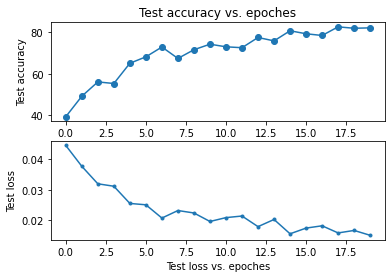

In [1]:
  # --------------------数据展示---------------------------------
import numpy as np
import matplotlib.pyplot as plt
import os

checkPointPath = '../DBtest/checkPoint/ResNet_checkPoint/'

if os.path.exists(checkPointPath + 'loss.npy'):
    Loss_list = np.load(checkPointPath + 'loss.npy', allow_pickle=True)
else:
    Loss_list = []

if os.path.exists(checkPointPath + 'accuracy.npy'):
    Accuracy_list = np.load(checkPointPath + 'accuracy.npy', allow_pickle=True)
else:
    Accuracy_list = []

x1 = range(0, len(Loss_list))
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()